# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [1]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import NZN_Office_parameter_set
from NZN_Office_parameter_set import internal_load_parameters
from NZN_Office_parameter_set import IAQ_parameters
from NZN_Office_parameter_set import lighting_parameters
from NZN_Office_parameter_set import architectural_parameters
from NZN_Office_parameter_set import infiltration_parameters
from NZN_Office_parameter_set import service_water_parameters
from NZN_Office_parameter_set import system_parameters
from NZN_Office_parameter_set import FCU_parameters
from NZN_Office_parameter_set import VAV_parameters
from NZN_Office_parameter_set import CB_parameters
from NZN_Office_parameter_set import plant_parameters
from NZN_Office_parameter_set import plant_temperature_parameters
from NZN_Office_parameter_set import plant_efficiency_parameters
from NZN_Office_parameter_set import pump_parameters
from NZN_Office_parameter_set import renewable_parameters

# Default Building Generator

In order to provide valid comparison across different sets of parameters, and to systematically QA parameter sets, a default building is generated.
This will also be useful to make sure that there is consistency among idfs used if changes are made to the idf and re-uploaded and not all parameters are used in the parameter set.

### To do
- Add function that changes runperiod to full runtime

In [3]:
#full parameter list

parameters = architectural_parameters()[0]
parameters.extend(internal_load_parameters()[0])
parameters.extend(IAQ_parameters()[0])
parameters.extend(lighting_parameters()[0])
parameters.extend(infiltration_parameters()[0])
parameters.extend(system_parameters()[0])
parameters.extend(FCU_parameters()[0])
parameters.extend(VAV_parameters()[0])
parameters.extend(CB_parameters()[0])
parameters.extend(plant_parameters()[0])
parameters.extend(plant_temperature_parameters()[0])
parameters.extend(plant_efficiency_parameters()[0])
parameters.extend(pump_parameters()[0])
parameters.extend(service_water_parameters()[0])
parameters.extend(renewable_parameters()[0])

/home/user/.local/lib/python3.7/site-packages/besos/parameters.py:404: FutureWarning: Use value_descriptors instead of value_descriptor.
  FutureWarning("Use value_descriptors instead of value_descriptor.")


In [4]:
# parameters

In [5]:
#full defaults list

defaults = architectural_parameters()[1]
defaults.update(internal_load_parameters()[1])
defaults.update(IAQ_parameters()[1])
defaults.update(lighting_parameters()[1])
defaults.update(infiltration_parameters()[1])
defaults.update(system_parameters()[1])
defaults.update(FCU_parameters()[1])
defaults.update(VAV_parameters()[1])
defaults.update(CB_parameters()[1])
defaults.update(plant_parameters()[1])
defaults.update(plant_temperature_parameters()[1])
defaults.update(plant_efficiency_parameters()[1])
defaults.update(pump_parameters()[1])
defaults.update(service_water_parameters()[1])
defaults.update(renewable_parameters()[1])

In [6]:
#convert dictionary to dataframe and view.
defaults_df = pd.DataFrame([defaults])

In [7]:
#Define the overall problem, etc

problem = EPProblem(parameters)
epw_victoria='CAN_BC_VictoriaUniversityCS_offset_from_Victoria-Univ.of.Victoria.717830_CWEC2016.epw'

default_building = ef.get_building('NZN_Medium_Office_Default_8.idf',data_dict='Energy+.idd')
evaluator = EvaluatorEP(problem, default_building,epw = epw_victoria,out_dir='outputs',multi=False)

In [8]:
#Remove all windows and shading using geomeppy
default_building.remove_windows()
default_building.remove_shading()

In [9]:
#Ensure we run a full year
default_building.idfobjects['RunPeriod'][0].Begin_Month=1
default_building.idfobjects['RunPeriod'][0].Begin_Day_of_Month=1
default_building.idfobjects['RunPeriod'][0].End_Month=12
default_building.idfobjects['RunPeriod'][0].End_Day_of_Month=31

In [10]:
#Save an idf version of the default building
evaluator.generate_building(defaults_df,index=0,file_name='NZN_Medium_Office_Default')

# Parametric Problem

## Parameters
Here we take a certain parameter set and use it for this study

In [11]:
parameters=[]
parameters.extend(architectural_parameters()[0])
parameters.extend(internal_load_parameters()[0])
parameters.extend(IAQ_parameters()[0])
parameters.extend(lighting_parameters()[0])
parameters.extend(infiltration_parameters()[0])
parameters.extend(system_parameters()[0])
parameters.extend(FCU_parameters()[0])
parameters.extend(VAV_parameters()[0])
parameters.extend(CB_parameters()[0])
parameters.extend(plant_parameters()[0])
parameters.extend(plant_temperature_parameters()[0])
parameters.extend(plant_efficiency_parameters()[0])
parameters.extend(pump_parameters()[0])
parameters.extend(service_water_parameters()[0])
parameters.extend(renewable_parameters()[0])

## Outputs
We need to define which outputs we'll be using to analyze the parameter sets

In [12]:
import NZN_Office_output_set
from NZN_Office_output_set import fuel_use
from NZN_Office_output_set import end_use_breakdown
from NZN_Office_output_set import metrics

In [13]:
outputs = fuel_use()
outputs.extend(end_use_breakdown())
outputs.extend(metrics())

In [14]:
#Drop any meters that don't currently exist in E+
outputs.remove('ExteriorLights:Electricity')
outputs.remove('InteriorEquipment:Gas')
outputs.remove('ExteriorEquipment:Electricity')
outputs.remove('ExteriorEquipment:Gas')
outputs.remove('WaterSystems:Electricity')
outputs.remove('Humidifier:Gas')

In [15]:
# outputs

## Problem Formation
This ties everything together into one problem set

In [16]:
problem = EPProblem(parameters,outputs)
num_runs=500
outdir='outputs'
inputs = sampling.dist_sampler(sampling.lhs, problem, num_runs)

building = ef.get_building('NZN_Medium_Office_Default.idf',data_dict='Energy+.idd')
evaluator = EvaluatorEP(problem, building, epw = epw_victoria,out_dir=outdir,multi=True,error_mode='Silent',error_value=None)

In [17]:
# inputs

In [ ]:
results = evaluator.df_apply(inputs,processes=16)

## Unit Conversion
The basic units used in the E+ meters are joules per year. We want to convert this to ekWh/m2.

In [ ]:
#Get floor area of building
#not sure why sql reader isn't working
import pathlib
output_path=pathlib.Path().absolute()
output_path=str(output_path.as_posix()+'/'+outdir+'/'+'eplusout.sql')
output_path
# floor_area=ef.read_sql(path=output_path,cmds=['floor area'])['floor area']
floor_area=4980

In [ ]:
#Function to do conversion
def J_to_ekwh_eui(energy_J, floor_area):
    energy_GJ=energy_J/1000000000
    energy_kwh=energy_GJ*277.8
    EUI=energy_kwh/floor_area
    return EUI

In [ ]:
results_EUI=J_to_ekwh_eui(results,floor_area)
# results_EUI.max()

In [84]:
#Filter any error'd simulation runs
results_EUI = inputs.join(results_EUI).replace([np.inf, -np.inf], np.nan).dropna().loc[:,results_EUI.columns]

inputs = inputs.join(results_EUI).replace([np.inf, -np.inf], np.nan).dropna().loc[:,inputs.columns]

In [85]:
results_EUI.replace([np.inf, -np.inf], np.nan)

Electricity:Facility  Gas:Facility  DistrictHeating:Facility  \
1              184.542492    347.414491                  0.000000   
2              165.784063    294.402950                  0.000000   
3               92.948945    115.399635                  0.000000   
4               68.463250    231.798397                  0.000000   
5              201.458160    498.295403                  0.000000   
..                    ...           ...                       ...   
494             44.200884    184.947559                  0.000000   
495             75.859289    444.711620                  0.000000   
497            181.061667     65.850233                  0.000384   
498            137.596009     60.115945                  0.000000   
499             98.229689    198.921608                  0.000000   

     DistrictCooling:Facility  Heating:Electricity  Heating:Gas  \
1                    0.000000             0.000000   170.947345   
2                    4.969680             0.000000   115.600775   
3                    0.000000            43.470844     0.000000   
4                    0.000000             0.000000   176.758823   
5                    0.008041             0.000000   346.720294   
..                        ...                  ...          ...   
494                  0.000034             0.000000    60.626076   
495                  0.000000             0.000000   252.494128   
497                  0.000000            21.827935     0.155868   
498                  0.000000            13.490911     0.000000   
499                  0.097529             0.000000    82.520985   

     Heating:DistrictHeating  Cooling:Electricity  Cooling:DistrictCooling  \
1                   0.000000            17.656587                 0.000000   
2                   0.000000            25.410857                 4.969680   
3                   0.000000             3.380711                 0.000000   
4                   0.000000             6.094531                 0.000000   
5                   0.000000            26.624188                 0.008041   
..                       ...                  ...                      ...   
494                 0.000000             2.847407                 0.000034   
495                 0.000000             5.990351                 0.000000   
497                 0.000384            11.573500                 0.000000   
498                 0.000000             6.248447                 0.000000   
499                 0.000000             8.269416                 0.097529   

     InteriorLights:Electricity  InteriorEquipment:Electricity  \
1                     59.629102                      31.661285   
2                     23.834870                      54.582516   
3                     13.061324                      21.858790   
4                     15.547511                      26.218476   
5                     58.518066                      47.409362   
..                          ...                            ...   
494                   27.339034                       7.868364   
495                   37.053681                      17.471517   
497                   44.720017                      28.006601   
498                   47.007909                      53.413154   
499                   18.807578                      35.683240   

     Fans:Electricity  Pumps:Electricity  HeatRejection:Electricity  \
1            3.294532          71.642275               0.000000e+00   
2           25.505819          18.728540               2.442469e-01   
3            5.597749           4.842060               2.891300e-05   
4           10.685227           7.199053               1.653624e-07   
5            6.722701          60.171912               6.814352e-04   
..                ...                ...                        ...   
494          2.453162           1.458510               1.126756e-04   
495          6.555384           7.352622               3.777357e-07   
49

In [ ]:
#Lets pickle these to store for later

inputs.to_pickle('overall_inputs.p')
results_EUI.to_pickle('overall_results.p')

In [83]:
inputs = pd.read_pickle('overall_inputs.p')
results_EUI = pd.read_pickle('overall_results.p')

# Surrogate Model
A surrogate model will be used to speed up the analysis process. After the initial sampling, the surrogate will be used to do a massive re-sampling to feed into our statistics.

The general steps to create a surrogate model are:
- Create the general architecture
- Identify hyper-parameters
- Normalize the inputs
- Normalize the outputs
- Split to training & testing set
- Train the ML model
- Validate

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [87]:
inputs_onehot=pd.get_dummies(inputs)

## Train-Test Split
We'll do 80/20 train/test split here

In [88]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.   
Different options for normalization exist.  
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.  
Note that we fit the normalizer on training data only.

In [89]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.fit_transform(X=test_in)

scaler_out = StandardScaler()
NN_outputs = scaler_out.fit_transform(X=train_out)
NN_outputs_test=scaler_out.fit_transform(X=test_out)

In [90]:
# NN_outputs

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [91]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)

#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)



In [92]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*25, kernel_regularizer='l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*25, kernel_regularizer='l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)

#output layer
output_layer = layers.Dense(units=num_outputs)(activation_2)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [93]:
print(model.summary())
# plot_model(model)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 98)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2450)              242550    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2450)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2450)              6004950   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2450)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 18)                44118     
Total params: 6,291,618
Trainable params: 6,291,618
Non-trainable params: 0
_________________________________________________

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [94]:
loss = 'mean_absolute_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [95]:
history=model.fit(x=NN_inputs,y=NN_outputs,batch_size=10,epochs=100, validation_split=0.2)

test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/100
29/29 [==============================] - 1s 23ms/step - loss: 11.6023 - mae: 0.5378 - mse: 0.9280 - val_loss: 2.5271 - val_mae: 0.4412 - val_mse: 0.9411
Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 1.2025 - mae: 0.3811 - mse: 0.7309 - val_loss: 0.7176 - val_mae: 0.3819 - val_mse: 0.8720
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5855 - mae: 0.3478 - mse: 0.6812 - val_loss: 0.5467 - val_mae: 0.3746 - val_mse: 0.8547
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.4880 - mae: 0.3380 - mse: 0.6678 - val_loss: 0.4954 - val_mae: 0.3586 - val_mse: 0.8201
Epoch 5/100
29/29 [==============================] - 1s 19ms/step - loss: 0.4546 - mae: 0.3233 - mse: 0.6207 - val_loss: 0.4750 - val_mae: 0.3539 - val_mse: 0.8075
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.4446 - mae: 0.3235 - mse: 0.6246 - val_loss: 0.4951 - val_mae: 0.3803 - val_mse: 0.8016
Epoch 7/100
29/

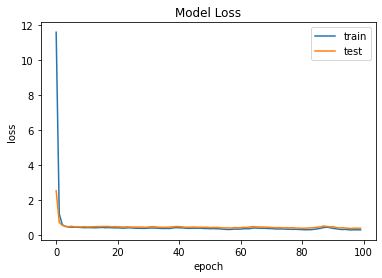

In [96]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [97]:
test_eval=model(NN_inputs_test,training=False)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [98]:
# test_eval_df
# test_out

## Visually Compare the test dataset

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [100]:
results_EUI.columns
end_uses=results_EUI.columns[2:-2]

This plotly chart is an interactive chart that will show the end-use breakdown in bar charts. It compares the results of a NN and the original E+ simulations.

In [101]:
# traces=[]
# buttons=[dict(label = "All",
#                  method = "update",
#                  args = [{"visible": True}])]

# for row in test_eval_df.index.to_list():
#     visibles=[False]*len(test_eval_df.index)
#     visibles[row]=True
    
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_eval_df.iloc[row][end_uses],
#             name = (f"NN: {row}"),
#             yaxis="y2"
#         ))
    
#     buttons.append(
#     dict(label = str(row),
#                  method = "update",
#                  args = [{"visible": visibles}])
#     )
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_out.iloc[row][end_uses],
#             name = (f"E+: {row}"),
#             yaxis="y2"
            
#         ))   
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Table(
#             header=dict(
#                 values=test_in.columns,
#                 font=dict(size=10),
#                 align="left"
#             ),
#             cells=dict(
#                 values=test_in.iloc[row].tolist(),
#                 align = "left")
#         ))    

    
# updatemenus=[dict(active=-1,
#          buttons=buttons)]
    
# layout = dict(title="Dropdown",
#               showlegend=True,
#               xaxis=dict(title="Source"),
#               yaxis=dict(title="Number", range=(-5, test_eval_df[end_uses].max().max()*1.1)),
#               updatemenus=updatemenus,
#               height=600)

# fig = make_subplots(rows=2,cols=1,
#                    row_heights=[.3,.7])
                         
# fig.add_traces(traces)
# fig.update_layout(layout)
# fig.show()

We've noticed that the main parameters affected by this parameter set are the heating:gas, and humidifier:electricity parameters. Let's look at R2 plots for these two parameters

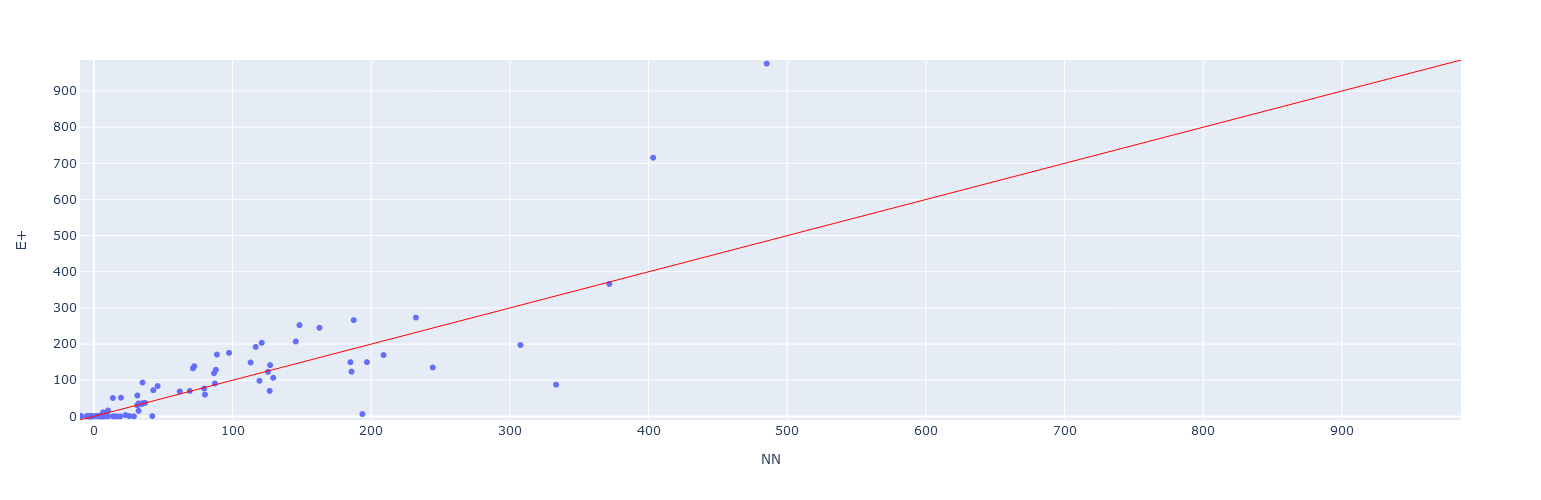

In [102]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

variable='Heating:Gas'
min_range=test_out[variable].min()-10
max_range=test_out[variable].max()+10

fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
fig.update_layout(
        yaxis=dict(range=[min_range,max_range]),
        xaxis=dict(range=[min_range,max_range]),
        xaxis_title='NN',
        yaxis_title='E+',
        height=500,
        width=500)

fig.add_shape(
        # 1-1 Line
        dict(
            type="line",
            x0=min_range,
            y0=min_range,
            x1=max_range,
            y1=max_range,
            line=dict(
                color="Red",
                width=1
            )))
fig.show()

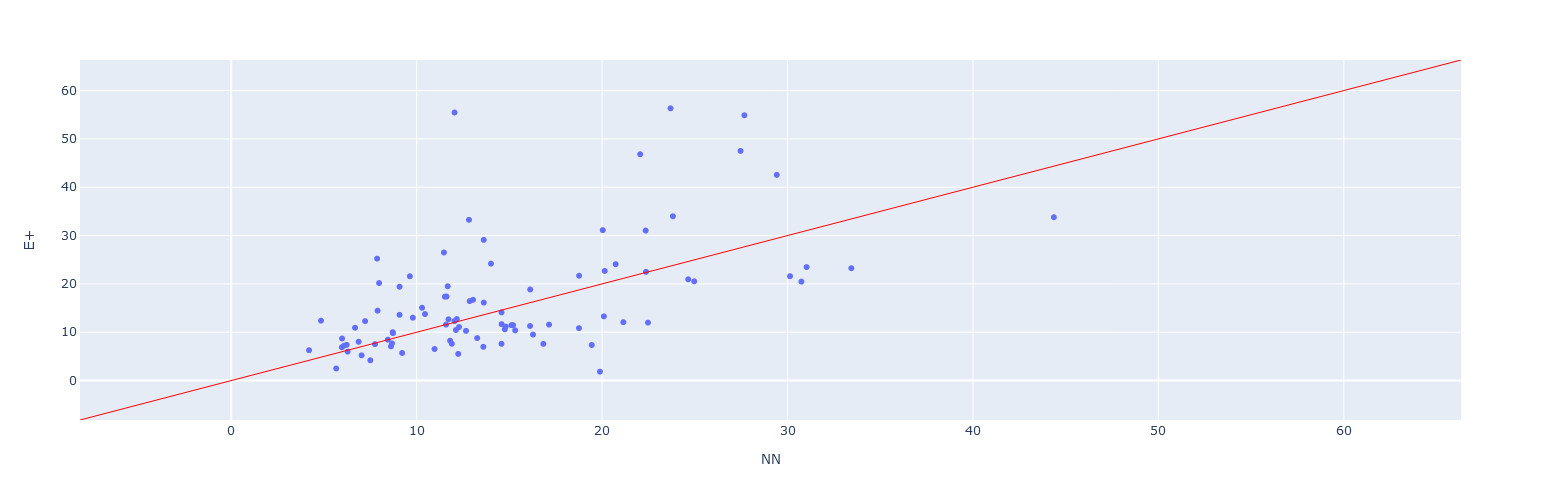

In [103]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

variable='Cooling:Electricity'
min_range=test_out[variable].min()-10
max_range=test_out[variable].max()+10

fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
fig.update_layout(
        yaxis=dict(range=[min_range,max_range]),
        xaxis=dict(range=[min_range,max_range]),
        xaxis_title='NN',
        yaxis_title='E+',
        height=500,
        width=500)

fig.add_shape(
        # 1-1 Line
        dict(
            type="line",
            x0=min_range,
            y0=min_range,
            x1=max_range,
            y1=max_range,
            line=dict(
                color="Red",
                width=1
            )))
fig.show()

# Visualization

In [104]:
results_EUI

Electricity:Facility  Gas:Facility  DistrictHeating:Facility  \
1              184.542492    347.414491                  0.000000   
2              165.784063    294.402950                  0.000000   
3               92.948945    115.399635                  0.000000   
4               68.463250    231.798397                  0.000000   
5              201.458160    498.295403                  0.000000   
..                    ...           ...                       ...   
494             44.200884    184.947559                  0.000000   
495             75.859289    444.711620                  0.000000   
497            181.061667     65.850233                  0.000384   
498            137.596009     60.115945                  0.000000   
499             98.229689    198.921608                  0.000000   

     DistrictCooling:Facility  Heating:Electricity  Heating:Gas  \
1                    0.000000             0.000000   170.947345   
2                    4.969680             0.000000   115.600775   
3                    0.000000            43.470844     0.000000   
4                    0.000000             0.000000   176.758823   
5                    0.008041             0.000000   346.720294   
..                        ...                  ...          ...   
494                  0.000034             0.000000    60.626076   
495                  0.000000             0.000000   252.494128   
497                  0.000000            21.827935     0.155868   
498                  0.000000            13.490911     0.000000   
499                  0.097529             0.000000    82.520985   

     Heating:DistrictHeating  Cooling:Electricity  Cooling:DistrictCooling  \
1                   0.000000            17.656587                 0.000000   
2                   0.000000            25.410857                 4.969680   
3                   0.000000             3.380711                 0.000000   
4                   0.000000             6.094531                 0.000000   
5                   0.000000            26.624188                 0.008041   
..                       ...                  ...                      ...   
494                 0.000000             2.847407                 0.000034   
495                 0.000000             5.990351                 0.000000   
497                 0.000384            11.573500                 0.000000   
498                 0.000000             6.248447                 0.000000   
499                 0.000000             8.269416                 0.097529   

     InteriorLights:Electricity  InteriorEquipment:Electricity  \
1                     59.629102                      31.661285   
2                     23.834870                      54.582516   
3                     13.061324                      21.858790   
4                     15.547511                      26.218476   
5                     58.518066                      47.409362   
..                          ...                            ...   
494                   27.339034                       7.868364   
495                   37.053681                      17.471517   
497                   44.720017                      28.006601   
498                   47.007909                      53.413154   
499                   18.807578                      35.683240   

     Fans:Electricity  Pumps:Electricity  HeatRejection:Electricity  \
1            3.294532          71.642275               0.000000e+00   
2           25.505819          18.728540               2.442469e-01   
3            5.597749           4.842060               2.891300e-05   
4           10.685227           7.199053               1.653624e-07   
5            6.722701          60.171912               6.814352e-04   
..                ...                ...                        ...   
494          2.453162           1.458510               1.126756e-04   
495          6.555384           7.352622               3.777357e-07   
49

In [105]:
inputs_onehot.join(results_EUI)

North WWR  East WWR  South WWR  West WWR  North Shading  East Shading  \
1     0.168638  0.929615   0.828986  0.602683       1.617891      0.632739   
2     0.472126  0.905340   0.915607  0.268352       0.638113      1.051663   
3     0.729145  0.249246   0.635120  0.898017       0.951493      1.727491   
4     0.897718  0.740229   0.299846  0.696430       0.932230      0.449181   
5     0.931400  0.362215   0.234998  0.923259       0.563144      1.041663   
..         ...       ...        ...       ...            ...           ...   
494   0.094507  0.506826   0.664531  0.194253       1.545141      0.861943   
495   0.113336  0.086542   0.884698  0.350780       1.797097      0.213407   
497   0.439442  0.181644   0.272499  0.318553       0.877214      0.345110   
498   0.654495  0.961025   0.191839  0.653692       0.400367      0.964174   
499   0.966284  0.668564   0.054415  0.913717       1.210789      1.122311   

     South Shading  West Shading  Orientation  Wall Insulation R-Value  \
1         0.399911      0.940029   -69.237214                42.186724   
2         1.081034      1.615296   -27.789421                37.216361   
3         0.351436      1.954459    62.458912                51.877700   
4         0.842483      0.842196   -84.629662                49.421273   
5         1.100206      0.613116   -20.707527                50.830895   
..             ...           ...          ...                      ...   
494       0.522117      1.678403    -2.490156                59.205092   
495       1.070328      0.889631   -34.781912                 6.175038   
497       1.808011      1.904375   -75.396720                59.717134   
498       0.791152      1.884669    63.997685                32.236575   
499       1.565331      1.141183    65.867000                 5.767020   

     Roof Insulation  Glazing USI  Glazing SHGC  Wall Thermal Mass  \
1           0.213084     0.989432      0.298554           0.068904   
2           0.569195     2.991563      0.741942           0.082508   
3           0.136761     4.282444      0.258274           0.072502   
4           0.531871     2.959093      0.132931           0.059639   
5           0.466741     2.591901      0.361755           0.098933   
..               ...          ...           ...                ...   
494         0.054819     1.376180      0.109552           0.028794   
495         0.499451     4.462213      0.200893           0.083003   
497         0.411448     4.312100      0.277537           0.058164   
498         0.370274     5.143537      0.368531           0.075226   
499         0.765177     3.876982      0.777756           0.089390   

     Floor Thermal Mass  Slab Insulation  Occupancy  Plug Loads   Data Loads  \
1              0.061435         0.970125   6.890602    6.206202  4677.193315   
2              0.012829         0.017453  95.737918   11.182569  6904.251043   
3              0.028085         1.251919  15.613079    4.000617  3825.587976   
4              0.049233         0.903179  56.851126    4.279462  5607.184210   
5              0.069429         0.401732  14.428955    9.404296  6644.412316   
..                  ...              ...        ...         ...          ...   
494            0.070361         1.035124  54.237943    1.293536  1684.721589   
495            0.067537         1.785825  17.477061    3.378149  2678.817118   
497            0.068532         1.611035  46.913256    3.179800  8908.590775   
498            0.048426         0.007042  70.089004   12.514598  3597.950998   
499            0.034453         1.227680  28.364633    8.373890  2375.568540   

     Heating Setpoint  Cooling Setpoint  RH-Low Setpoint  RH-High Setpoint  \
1           21.020221         23.798525         8.676199         47.257391   
2           20.619886         25.350072        32.531232         52.068965   
3           18.656730         24.938485         6.532948         81.772330   
4           20.517921         25.823642        33.554766         

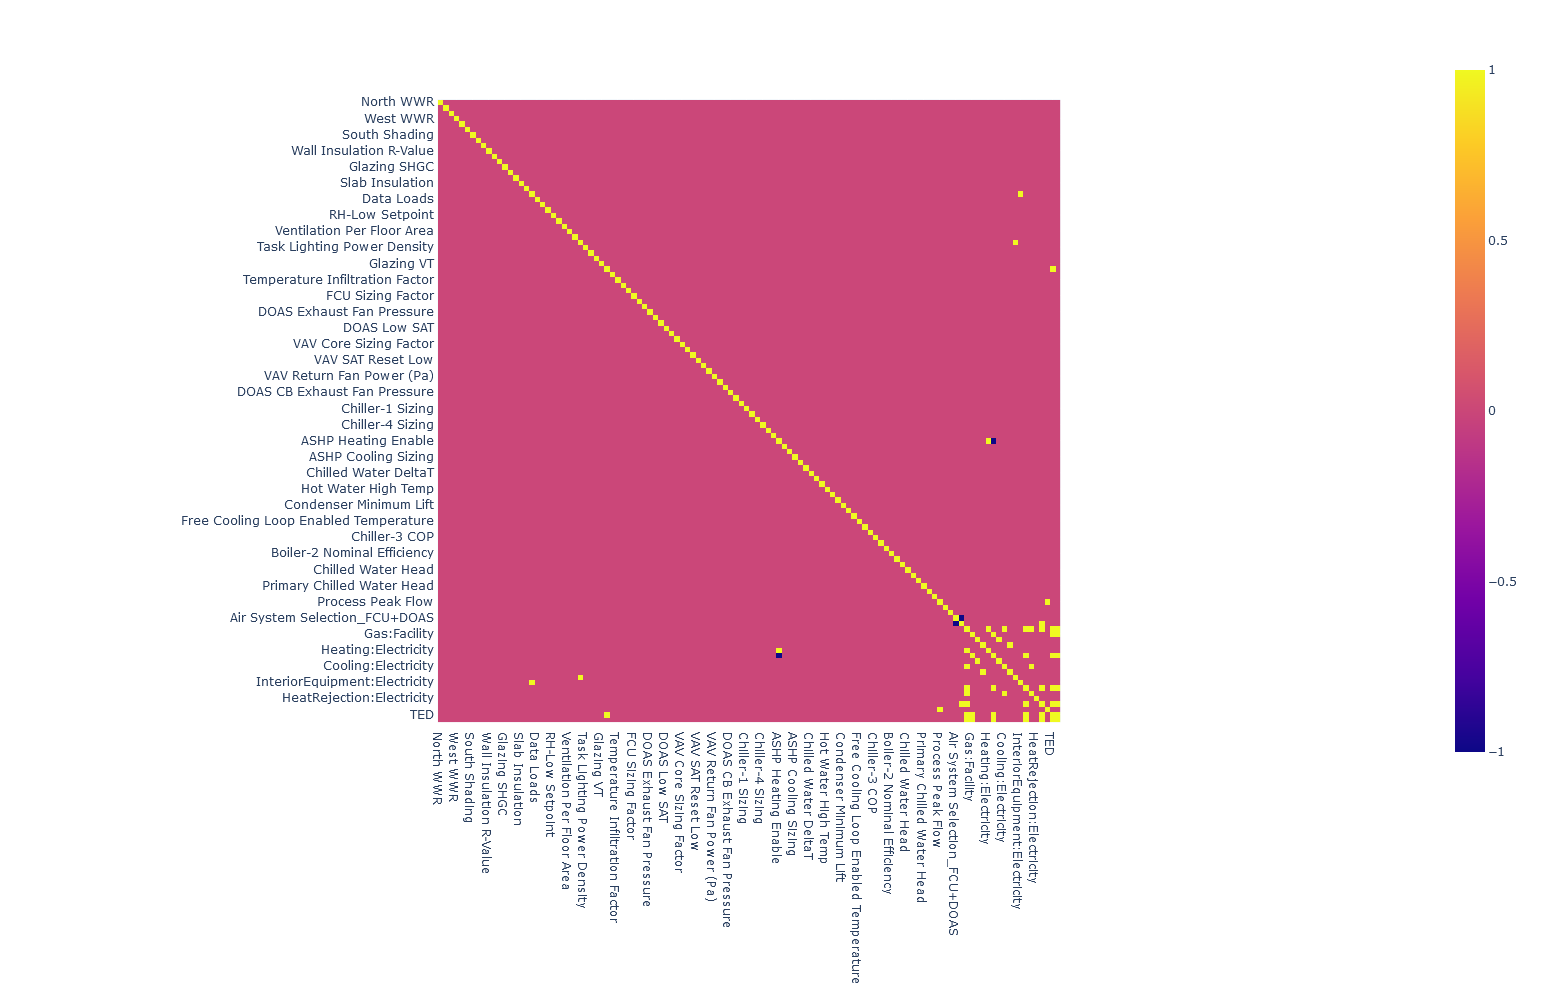

In [106]:
inputs_visualize=inputs_onehot.join(results_EUI)

fig = px.imshow(img=inputs_visualize.corr().round(),
               x=inputs_visualize.corr().columns,
               y=inputs_visualize.corr().index,
               height=1000,
               width=1000)
fig.show()

In [115]:
# #Scatter subplots of inputs vs outputs for E+ runs.
# #We'll have a row for each input and a column for the outputs we are interested in.
# # For now, we are interested in Heating, Cooling, Fans, Humidifier, TED and TEU

# #for now we will do it quickly with express

# out_scatter=results_EUI.columns[-2:]
# in_scatter=inputs_onehot.columns[26:]

# rows=len(out_scatter)
# cols=len(in_scatter)

# fig = make_subplots(rows=rows,
#                     cols=cols,
#                     shared_xaxes=True, 
#                     shared_yaxes=True,
#                     vertical_spacing=0.01,
#                     horizontal_spacing=0.01)

# for row in range(0,rows):
#     for col in range(0,cols):
#         fig.add_trace(
#         go.Scatter(x=inputs_visualize[in_scatter[col]],y=inputs_visualize[out_scatter[row]],
#                   mode='markers',
#                   name=(f"{in_scatter[col]} x {out_scatter[row]}")),
#             row=row+1,col=col+1)
        
# for col in range(0,cols):
#     fig.update_xaxes(title_text=(f"{in_scatter[col]}"), row=rows, col=col+1)
    
# for row in range(0,rows):
#     fig.update_yaxes(title_text=(f"{out_scatter[row]}"), row=row+1,col=1)
        
# fig.update_layout(
#     height=800,
#     width=1000,
#     showlegend=False)

# fig.show()

# Store metadata

In [109]:
results_EUI.columns=['Electricity:Facility [ekWh/m2]', 'Gas:Facility [ekWh/m2]', 'DistrictHeating:Facility [ekWh/m2]',
       'DistrictCooling:Facility [ekWh/m2]', 'Heating:Electricity [ekWh/m2]', 'Heating:Gas [ekWh/m2]',
       'Heating:DistrictHeating [ekWh/m2]', 'Cooling:Electricity [ekWh/m2]',
       'Cooling:DistrictCooling [ekWh/m2]', 'InteriorLights:Electricity [ekWh/m2]',
       'InteriorEquipment:Electricity [ekWh/m2]', 'Fans:Electricity [ekWh/m2]',
       'Pumps:Electricity [ekWh/m2]', 'HeatRejection:Electricity [ekWh/m2]',
       'Humidifier:Electricity [ekWh/m2]', 'WaterSystems:Gas [ekWh/m2]', 'TED [ekWh/m2]', 'TEU [ekWh/m2]']

In [110]:
import pickle
pickle.dump([inputs_onehot.min(), inputs_onehot.max(), inputs_onehot.columns, results_EUI.columns, scaler_in, scaler_out, inputs_onehot, results_EUI], open('model_pickle','wb'))

# Store model

In [111]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Tensorflow js model

In [112]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [113]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)